In [259]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [260]:
csv_path = "dataset/BTC-USD.csv"

In [261]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [262]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [263]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

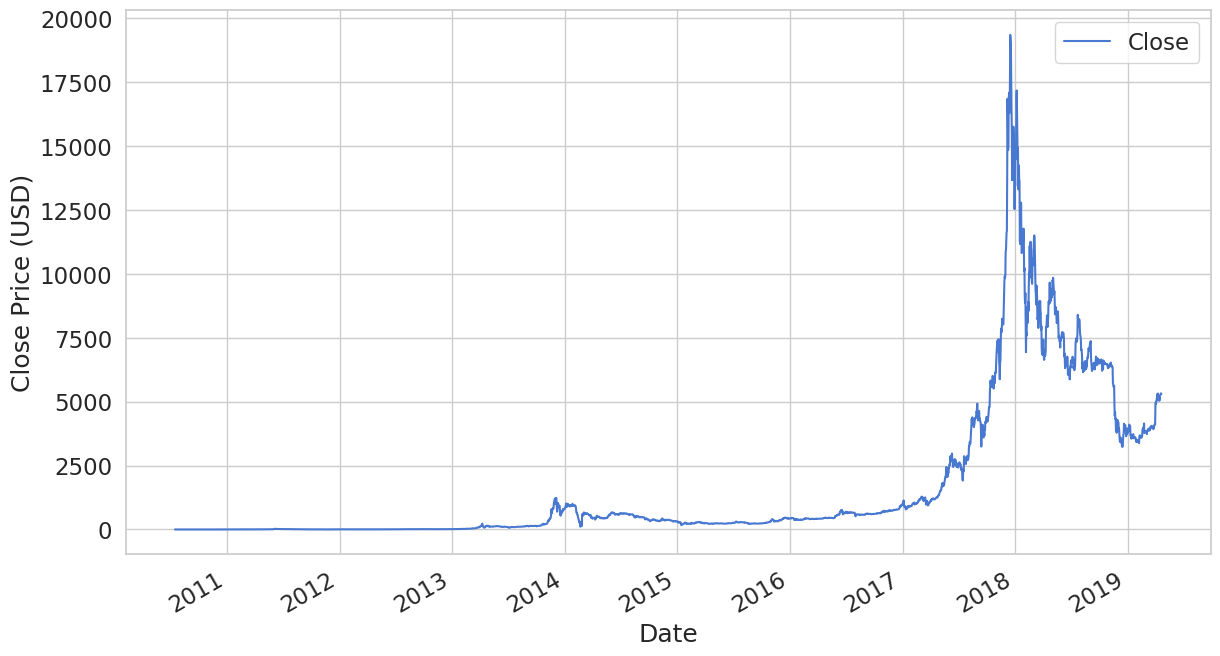

In [264]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [265]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [266]:
scaled_close.shape

(3201, 1)

In [267]:
np.isnan(scaled_close).any()

False

In [268]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [269]:
scaled_close = scaled_close.reshape(-1, 1)

In [270]:
np.isnan(scaled_close).any()

False

In [271]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [272]:
X_train.shape, X_test.shape

((2945, 99, 1), (156, 99, 1))

In [273]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [274]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [275]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=75, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 2.8280e-04 - val_loss: 0.0156
Epoch 2/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0090 - val_loss: 0.0079
Epoch 3/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0101 - val_loss: 0.0014
Epoch 4/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0024 - val_loss: 0.0066
Epoch 5/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 6/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0026 - val_loss: 0.0125
Epoch 7/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 8/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 4.2363e-04 - val_loss: 0.0162
Epoch 9/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0038 - val_loss: 0.0214
Epoch 10/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0155 - val_loss: 0.0520
Epoch 11/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 12/75
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - l

In [276]:
model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014


0.001126814866438508

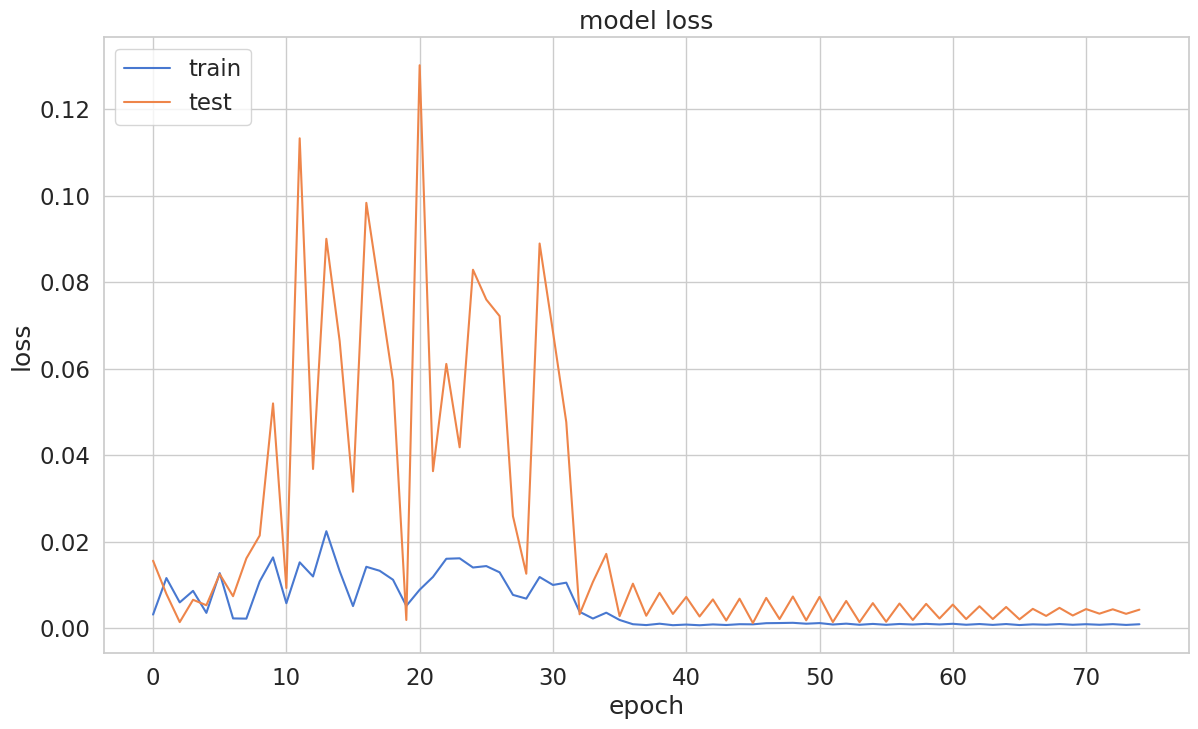

In [277]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


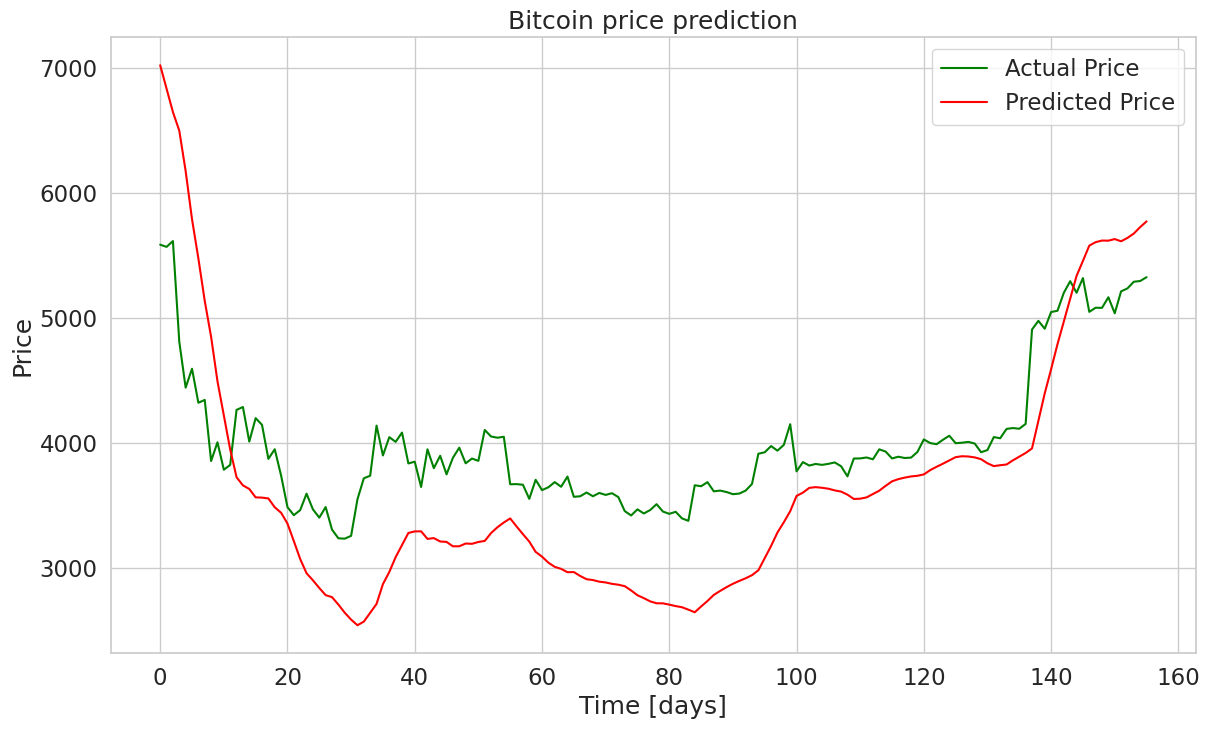

In [278]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


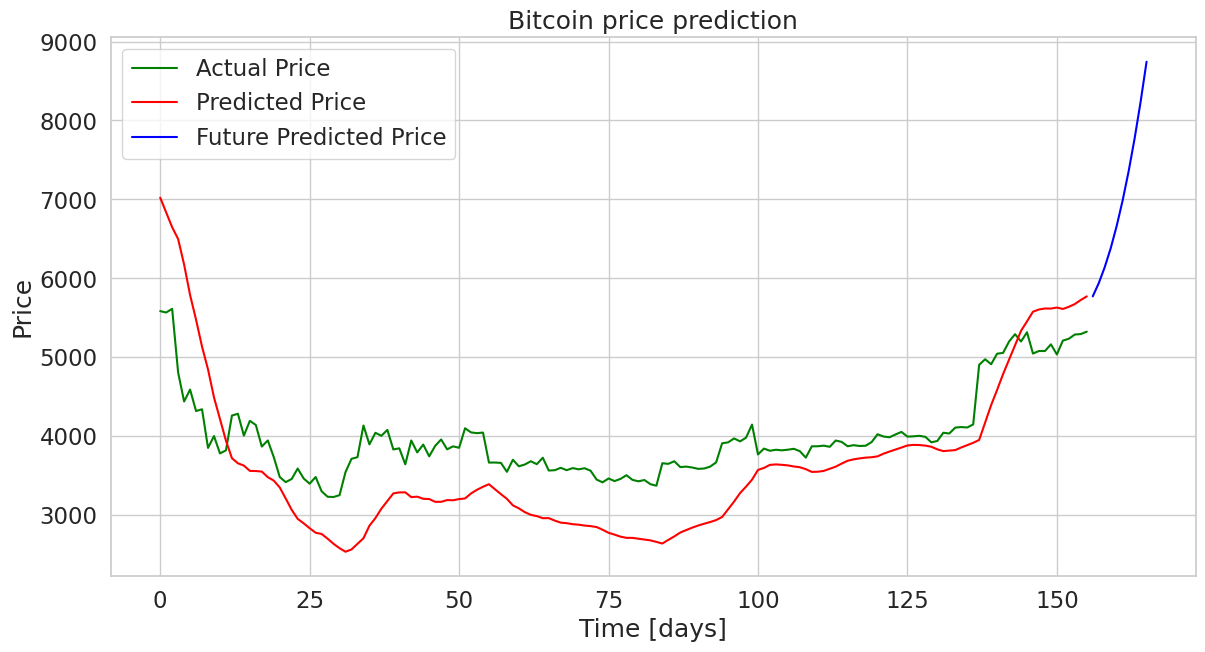

In [281]:
def predict_future(model, last_sequence, future_days):
    predicted_sequence = []
    current_sequence = last_sequence

    for _ in range(future_days):
        predicted_value = model.predict(current_sequence[np.newaxis, :, :])[0]
        predicted_sequence.append(predicted_value)
        current_sequence = np.append(current_sequence[1:], [predicted_value], axis=0)
    
    return np.array(predicted_sequence)

last_sequence = X_test[-1]

future_days = 10  

future_predictions = predict_future(model, last_sequence, future_days)

future_predictions_inverse = scaler.inverse_transform(future_predictions)

full_predictions = np.concatenate([y_hat_inverse, future_predictions_inverse])

plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
plt.plot(range(len(y_test_inverse), len(y_test_inverse) + future_days), future_predictions_inverse, label="Future Predicted Price", color='blue')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()